<a href="https://colab.research.google.com/github/hieplh/PPR501/blob/main/Exercise_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries Required

In [ ]:
!pip install pandas==1.1.3
!pip install pystan==2.19.1.1
!pip install fbprophet 

!pip install gdown
!rmdir dataset
!mkdir dataset

!gdown --folder https://drive.google.com/drive/folders/1DVCGeZnvEgdR9RQIhDaRTGHjeSGeCv7E?usp=sharing -O /content/dataset

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time
import math
import datetime


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 28.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 86 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.7 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638636 sha256=c5392496e05fbd405f1a06c481e01da79c7b391c5d0c6a868bda36926182d513
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492

Ở đây chúng ta dùng lệnh pip install *package* là để install các package mà chúng ta cần

*Nếu không chỉ định version thì mặc định python sẽ tải latest version cho chúng ta. Để chỉ định version cần tải, chúng ta cần thêm ký tự == và theo sau là version (package==version)*

```
!rmdir dataset
!mkdir dataset
```
Lần lượt là xóa thư mục tên là dataset nếu có và tạo mới thư mục tên dataset

Ở những dòng tiếp theo là để chúng ta khai báo các thư viện cần thiết cho chương trình. Với syntax import *tên package* hoặc from *tên package* import *tên class*

```
import <tên package> nghĩa là python sẽ import toàn bộ những gì mà package này có 
```
```
from <tên package> import <tên class> nghĩa là python sẽ chỉ import class thuộc package mà chúng ta đang khai báo
```

Phần cuối cùng là ta dùng package os để đọc toàn bộ file đang có theo đường dẫn /content/dataset và hiển thị đường dẫn tương đối của những file đấy nếu có




## Understanding the DataSet:

In [ ]:
sell_prices_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sell_prices.csv')
train_sales_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sales_train_validation.csv')
calendar_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/calendar.csv')
submission_file = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sample_submission.csv')

Ở đây chúng ta dùng pandas để đọc file csv được lưu ở github và lưu dữ liệu vào các biến

In [ ]:
sell_prices_df.info()
print()
train_sales_df.info()
print()
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  1

Lần lượt in ra thông tin đã đọc được từ đường dẫn trên

Với dữ liệu file nào nhiều cột, python sẽ chỉ hiển thị tổng số cột chứ không hiển thị dưới dạng bảng cho chúng ta

# EDA (Exploratory Data Analysis)

## Distribution of Sales On Weekdays & Special Occasions?

In [ ]:
train_sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


Method head() dùng để hiển thị số lượng record theo tham số đầu vào, tính từ tham số đầu tiên

In [ ]:
d_cols = [c for c in train_sales_df.columns if 'd_' in c]
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1)
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1)
#train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

Ở đây python sẽ duyệt dataframe của train_sales_df theo cột và sẽ lấy dữ liệu để gán vào biến d_cols nếu thỏa điều kiện bắt đầu bằng d_

Lần lượt đổ dữ liệu vào mảng với key là total_sales_all_days, avg_sales_all_days, median_sales_all_days

Tham số axis có 2 giá trị, 0 và 1

*   0 nghĩa là tính toán theo dòng
*   1 nghĩa là tính toán theo cột

Ở đây ta có 3 hàm (sum, mean, median)

*   sum nghĩa là tính tổng
*   mean nghĩa là tính trung bình cộng
*   median nghĩa là tìm giá trị ở giữa của tập giá trị cho trước





In [ ]:
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Distribution of Product_IDs Across Categories')
fig.show()

```
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
```
Dòng này là để chúng ta nhóm dữ liệu với một cột làm chuẩn là cat_id của dataframe train_sales_df. Sau đó ta sẽ tính tổng số lượng record dựa trên id và đặt tên cho cột mới này là total_entries

```
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Distribution of Product_IDs Across Categories')
fig.show()
```
Ở đây ta sẽ vẽ biểu đồ tròn với dữ liệu đầu vào là từ biến df ở trên, dữ liệu để tính toán là cột total_entries, và tên cho từng phần được tính toán sẽ lấy từ cột cat_id.
Tiếp theo là đổ màu tuyến tính, độ rộng và cao, và tên của biểu đồ.

Cuối cùng là hiển thị biểu đồ

In [ ]:
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()
fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Distribution of Total_Sales Across States')
fig.show()

In [ ]:
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

In [ ]:
df = train_sales_df.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Distribution of Product_ids Count Across Categories & Each Locale")
fig.show()

Ở đây là ta sẽ vẽ biểu đồ cột theo dữ liệu cho trước và cột x, y cho trước

## Distribution of Items Across Department & Store_ids?

In [ ]:
df = train_sales_df.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[train_sales_df.columns[6:]].sum().reset_index()
df = df.sort_values('total_sales_all_days', ascending=False)

In [ ]:
x_dept = df['dept_id']
x_store = df['store_id']

def items_sold_per_days(x_spec,title_text, title):
    
    '''
    returns plotly plots with drop down menus for specified parameter made in dataframe earlier
    
    inputs: x_spec (categorical feature on the x_axis), title_text(title on dropdown), 
            title (title of the plot)
            
    returns: plotly plots of categorical feature (x_axis) with dropdowns on specific 
    number of days        
    '''
    
    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']

    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}], 
                 label = cols[k])   for k in range(0, len(cols))]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))

    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450, 
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]); 

    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));
    fig.show()

items_sold_per_days(df['store_id'], 'Distribution of Sales Made on Each Store', 'Stores')
items_sold_per_days(df['state_id'], "Distribution of Sales Made In Each State", 'States')

## Specific Item OutSelling the Most?

In [ ]:
train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_057_WI_2_validation            16
FOODS_2_071_TX_3_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

Dòng này là để nhóm theo id và tính tổng dựa trên total_sales_all_days và sau đó sắp xếp theo chiều giảm dần

In [ ]:
df_agg = pd.DataFrame(train_sales_df.groupby(['id', 'cat_id', 'store_id'])['total_sales_all_days'].sum().sort_values(ascending=False))
df_agg = df_agg.reset_index()
df_agg.head(3)

,id,cat_id,store_id,total_sales_all_days
0,FOODS_3_090_CA_3_validation,FOODS,CA_3,250502
1,FOODS_3_586_TX_2_validation,FOODS,TX_2,192835
2,FOODS_3_586_TX_3_validation,FOODS,TX_3,150122


Dòng này là để nhóm theo id, cat_id và store_id, sau đó tính tổng dựa trên total_sales_all_days, sắp xếp giảm dần và đổ dữ liệu vào 1 DataFrame

Cuối cùng là hiển thị 3 record đầu tiên của DataFrame trên

In [ ]:
print("The 3 item_ids outselling most in FOODS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])))
print("The 3 item_ids outselling most in HOUSEHOLDS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOUSEHOLD']['id'][:3])))
print("The 3 item_ids outselling most in HOBBIES category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOBBIES']['id'][:3])))

The 3 item_ids outselling most in FOODS category are: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']
The 3 item_ids outselling most in HOUSEHOLDS category are: ['HOUSEHOLD_1_118_CA_3_validation', 'HOUSEHOLD_1_459_CA_3_validation', 'HOUSEHOLD_1_334_CA_3_validation']
The 3 item_ids outselling most in HOBBIES category are: ['HOBBIES_1_234_CA_3_validation', 'HOBBIES_1_348_CA_1_validation', 'HOBBIES_1_371_CA_1_validation']


3 dòng code ở đây là dùng để in ra 3 item đầu tiên, theo danh sách từ trên xuống, mà được bán chạy nhất ở các danh mục như là foods, households, hobbies

Tại sao 3 item đầu lại là những item bán chạy nhất? Bởi vì ở đoạn code [13] chúng ta đã lọc theo tổng doanh số sản phẩm đã bán được theo thứ tự giảm dần

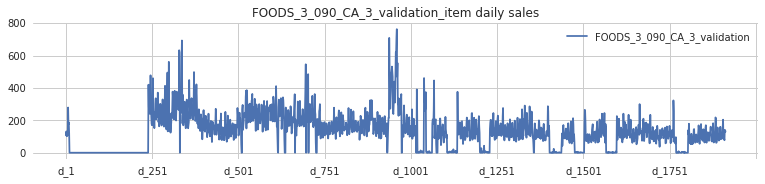

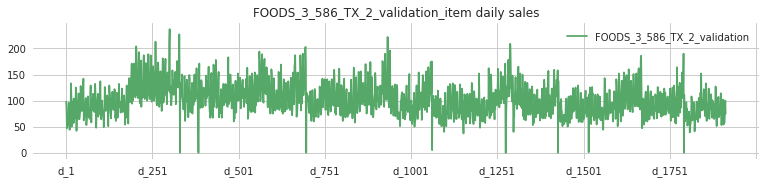

In [ ]:
sns.set_style('whitegrid')

def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols]\
                .T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    plt.legend()
    plt.show()

plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

Method plot_dailysales này sẽ nhận vào 1 tham số là id của sản phẩm, lọc dữ liệu theo id đầu vào từ 1 tập dữ liệu đã được chỉ định trước và hiển thị biểu đồ đường các giá trị của sản phẩm đấy qua từng ngày

## Item ID Outselling Most in Each Category?

In [ ]:
def plot_sample_sales(spec_id, sm_start, sm_end, samples_pick=50):
    """
    plots sample sales data with selection point and ending point specified, along with
    samples_pick point that specifies the samples picked after specified intervals
    
    input: spec_id (item_id or id), sm_start (sample_start), sm_end(sample_end),
    samples_pick (samples picked after how many intervals)
    
    returns: outputs a graph of sample points plotted against daily sales data d_1 to d_1913
    """
    fig, ax1 = plt.subplots(figsize=(13, 2.5))
    
    x1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .columns)[sm_start:sm_end]
    y1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .values.flatten())[sm_start:sm_end]
    
    #this conversion for regplot only
    x1 = [x.replace("d_", "") for x in x1]
    x1 = [int(x) for x in x1]
    
    #sns.lineplot(x=x1, y=y1, ax=ax1)
    sns.regplot(x=x1, y=y1, order=10, ax=ax1)
    ax1.set_ylabel("Number of Sales")
    ax1.set_xlabel("Days")

    ax1.set_xticks(x1[::samples_pick])
    ax1.set_xticklabels(x1[::samples_pick], rotation=0)

    fig.tight_layout()
    plt.show()

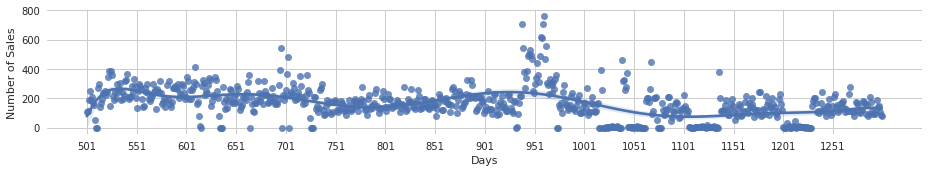

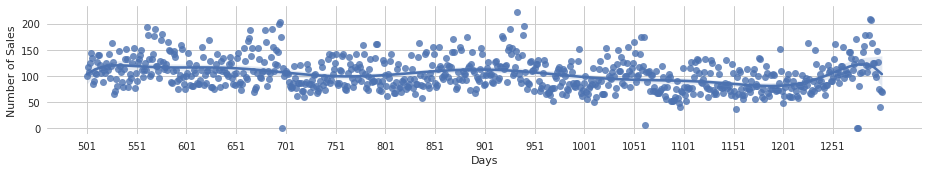

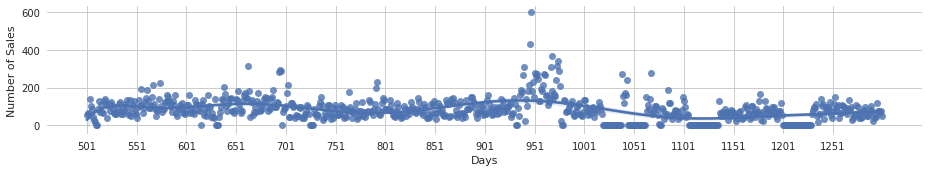

In [ ]:
plot_sample_sales('FOODS_3_090_CA_3_validation', 500, 1300)
plot_sample_sales('FOODS_3_586_TX_2_validation', 500, 1300)
plot_sample_sales('FOODS_3_090_CA_1_validation', 500, 1300)

In [ ]:
# making a new column category out of the item_id 
sell_prices_df['category'] = sell_prices_df['item_id'].str.split("_", expand=True)[0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



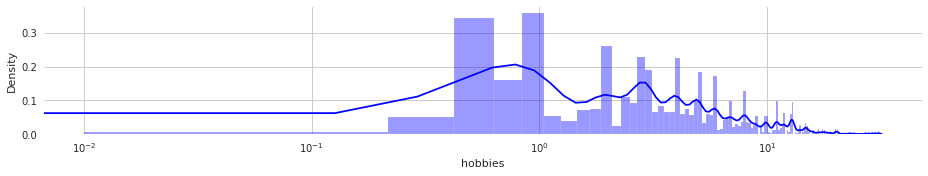

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



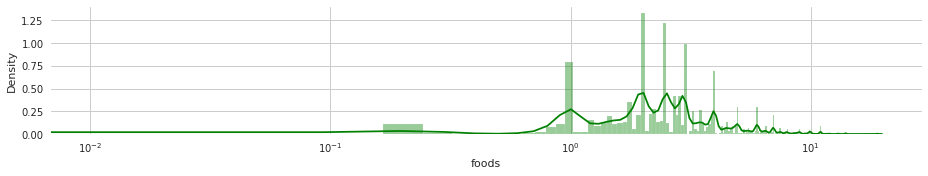

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



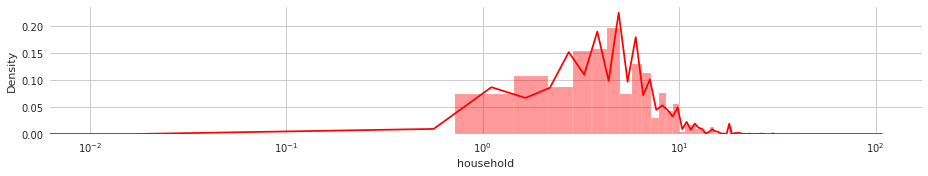

In [ ]:
sns.set_style('whitegrid')
#plt.figure(figsize=(15,5))

def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )

    sns.distplot(df[df['category'] == category]['sell_price'], 
               axlabel = label ,bins=bin_size, color = color, ax=ax1) 

    fig.tight_layout()
    ax1.set_xscale('log')
    plt.legend()
    plt.show()
    
kde_plotting(sell_prices_df, 'HOBBIES', 150, 'b', 'hobbies')   
kde_plotting(sell_prices_df, 'FOODS', 250, 'g', 'foods') 
kde_plotting(sell_prices_df, 'HOUSEHOLD', 150, 'r', 'household') 

In [ ]:
def remove_outliers(df):
    
    '''
    removes the outliers in continous features using quartile ranges
    
    inputs: df(df specified with continous features along side categorical features)
    returns: df with removed outliers
    '''
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return df_final

df = sell_prices_df[['category', 'sell_price']]
df = remove_outliers(df)

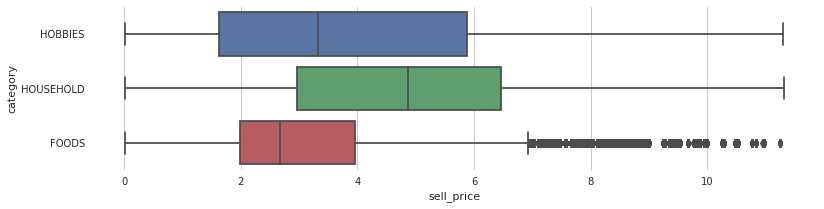

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.boxplot(y=df['category'], x=df['sell_price'])
plt.show()

In [ ]:
calendar_df.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
calendar_df.groupby(['event_name_1', 'event_type_1'])['wday'].count()

event_name_1         event_type_1
Chanukah End         Religious       5
Christmas            National        5
Cinco De Mayo        Cultural        5
ColumbusDay          National        5
Easter               Cultural        5
Eid al-Fitr          Religious       5
EidAlAdha            Religious       5
Father's day         Cultural        4
Halloween            Cultural        5
IndependenceDay      National        5
LaborDay             National        5
LentStart            Religious       6
LentWeek2            Religious       6
MartinLutherKingDay  National        5
MemorialDay          National        6
Mother's day         Cultural        6
NBAFinalsEnd         Sporting        6
NBAFinalsStart       Sporting        6
NewYear              National        5
OrthodoxChristmas    Religious       5
OrthodoxEaster       Religious       5
Pesach End           Religious       6
PresidentsDay        National        6
Purim End            Religious       6
Ramadan starts       Religious

## What are **SNAP_CA, SNAP_TX, SNAP_WI**?

In [ ]:
#Making in and including a new entry of days as well as merging the events_1 and event_2 into
# a single new events_names and types category

calendar_df['days'] = [d.split('-')[2] for d in calendar_df['date']]
calendar_df['events_names'] = pd.concat([calendar_df['event_name_1'], calendar_df['event_name_2']], 
                                        ignore_index=True)
calendar_df['events_types'] = pd.concat([calendar_df['event_type_1'], calendar_df['event_type_2']], 
                                        ignore_index=True)
#calendar_df.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)

In [ ]:
df = calendar_df.groupby(['events_types'])['snap_CA'].value_counts().reset_index(name='counts')

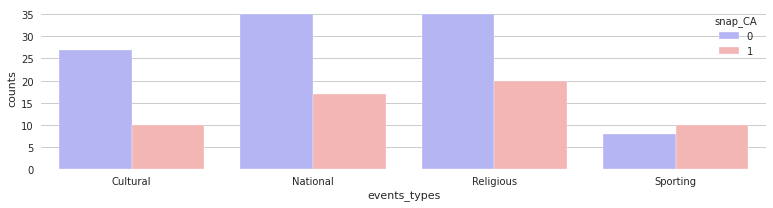

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_types', y='counts', hue='snap_CA', data=df, palette='bwr')
plt.show()

In [ ]:
df = calendar_df.groupby(['events_names'])['snap_CA'].value_counts().reset_index(name='counts')

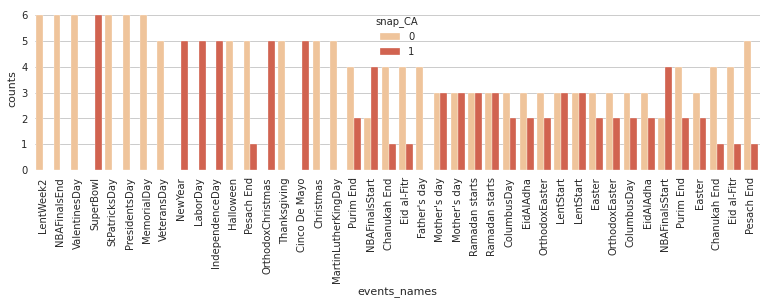

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_names', y='counts', hue='snap_CA', data=df, 
            order = df.sort_values(['counts'], ascending=False).events_names, 
            palette='OrRd')
plt.xticks(rotation=90)
plt.show()

## Distribution of Sales Items vs Sales Revenue? 

In [ ]:
#product id df (train_sales_df) vs revenue_df(sell_prices_df)
train_sales_prices_df = train_sales_df.merge(sell_prices_df, how='inner', on='item_id', 
                                            left_index=True, right_index=True, 
                                            validate="1:1")

Đoạn code này chúng ta sẽ join giữa 2 tập dữ liệu là sales_train_validation.csv và sell_prices.csv lại với nhau theo cách thức là inner join với khóa chính giữa 2 tập hợp là item_id

In [ ]:
df = train_sales_prices_df.groupby(['cat_id', 'state_id', 'store_id_x'])['sell_price'].sum().reset_index(name='total_revenue')
df = df.sort_values(by='total_revenue', ascending=False)

Tiếp theo chúng ta nhóm cat_id, state_id và store_id_x từ tập hợp để join được ở đoạn code [117] và tính tổng lại, sau đó đặt tên cho cột đã tính tổng đấy là total_revenue

Sau đấy là sắp xếp lại dữ liệu theo chiều giảm dần bằng cột total_revenue

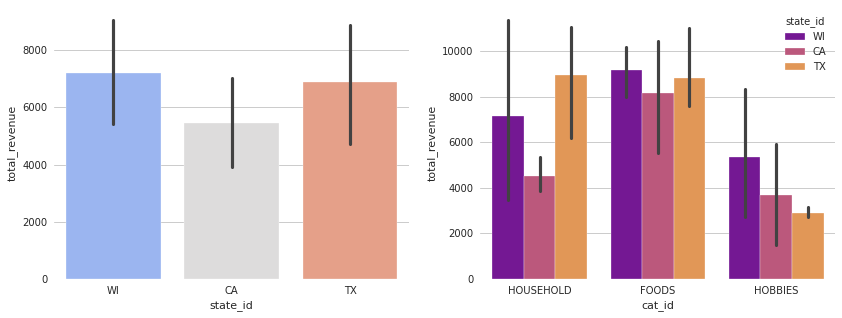

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'state_id', y='total_revenue', data=df, 
            palette='coolwarm', ax=ax1)
sns.barplot(x = 'cat_id', y='total_revenue', hue='state_id', data=df, 
            palette='plasma', ax=ax2)

# plt.xticks(rotation=90)
plt.show()

Cuối cùng, chúng ta thể hiện 2 biểu đồ cột


*   Biểu đồ bên trái để thể hiện tổng doanh thu của từng bang trên tất cả danh mục sản phẩm
*   Biểu đồ bên phải để thể hiện tổng doanh thu của từng danh mục sản phẩm theo từng bang



## *Behaviour on TimeSeries & Analysis?*

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

Ở đây ta sử dụng inner join với 2 tập hợp data là sales_train_validation.csv (train_sales_df) và calendar.csv (calendar_df)

Sau đó tính tổng theo cột dựa trên tập dữ liệu đã merge và gán dữ liệu vào train_sales_cal_df['total_sales']

In [ ]:
train_sales_cal_df = train_sales_cal_df[['total_sales']]
train_sales_cal_df = train_sales_cal_df.reset_index()

Lấy dữ liệu của train_sales_cal_df[['total_sales']] dưới dạng DataFrame

```
[] - single bracket : cú pháp để lấy dữ liệu dưới dạng là Pandas Series
[[]] - double brackets : cú pháp để lấy dữ liệu dưới dạng là Pandas DataFrame
```



In [ ]:
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Total Sales by Product id', 
             width=800, height=450)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict(buttons=list([
        dict(count=1, label="1m", step="month", stepmode="backward"),
        dict(count=6, label="6m", step="month", stepmode="backward"),
        dict(count=1, label="YTD", step="year", stepmode="todate"),
        dict(count=1, label="1y", step="year", stepmode="backward"),
        dict(step="all")
    ])),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

Tiếp theo ta vẽ biểu đồ đường dựa trên tập dữ liệu ở đoạn code trên, với x là thời gian và y là tổng lượng hàng bán được



In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: df(time series df), model_specified (whether additive or multiplicative ), period(number of days)
    returns: trend values, seasonality values and residual values of time_series df
    
    '''
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

sample_time_s1 = train_sales_cal_df[400:700]
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 
                                                              'multiplicative', 30)

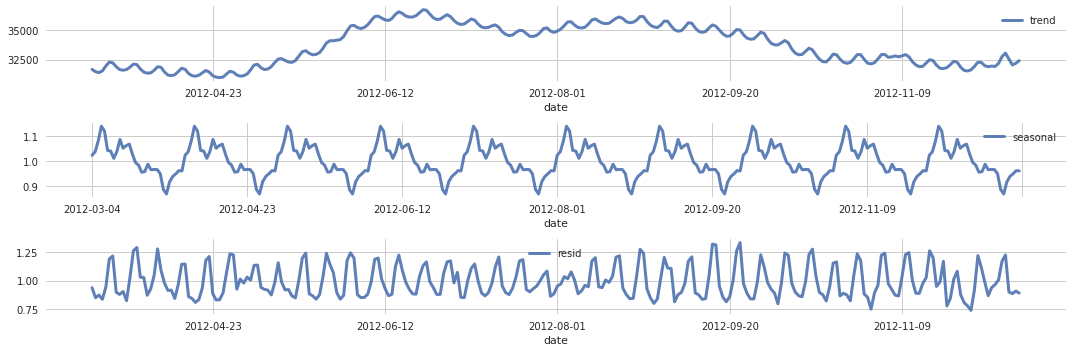

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

fig.tight_layout()
plt.show()

In [ ]:
train_sales_cal_df = train_sales_cal_df.set_index('date')

In [ ]:
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

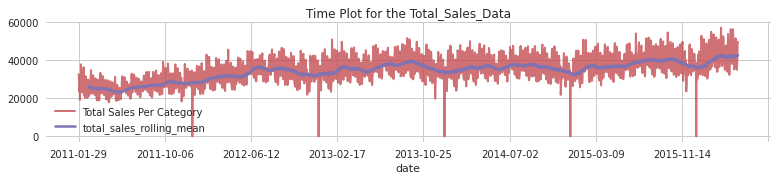

In [ ]:
time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')

In [ ]:
#finding the product_ids of 25 most sold units
train_sales_most_sold_25 = train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')
train_sales_most_sold_25.iloc[0:5]

,id,total_sales
0,FOODS_3_090_CA_3_validation,250502
1,FOODS_3_586_TX_2_validation,192835
2,FOODS_3_586_TX_3_validation,150122
3,FOODS_3_586_CA_3_validation,134386
4,FOODS_3_090_CA_1_validation,127203


In [ ]:
train_sales_most_sold_25['state'] = train_sales_most_sold_25['id'].str.split("_", expand=True)[3]
train_sales_most_sold_25.groupby(['state'])['total_sales'].sum().sort_values(ascending=False)

state
TX    1233196
CA    1005717
WI     470367
Name: total_sales, dtype: int64

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

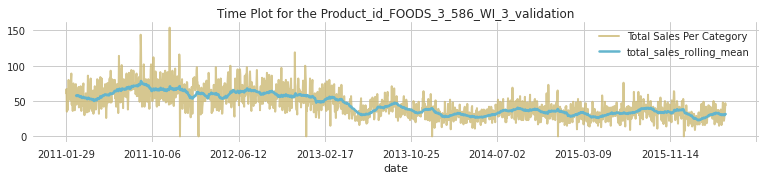

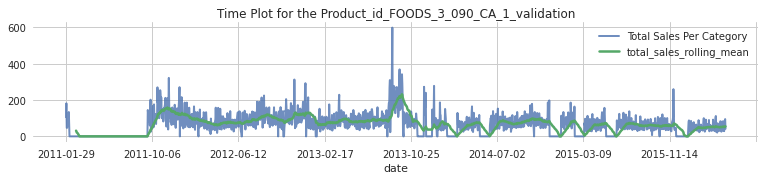

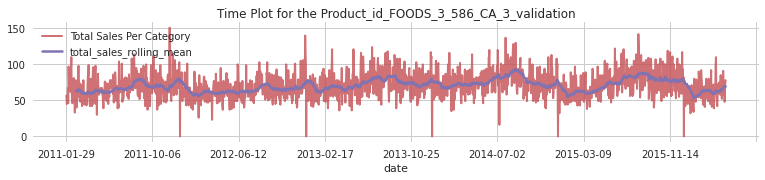

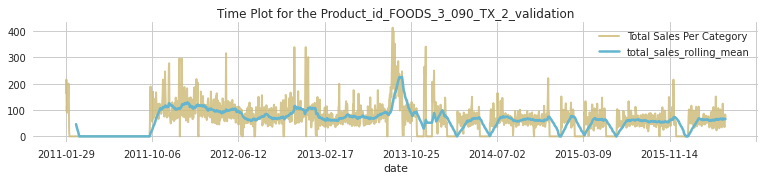

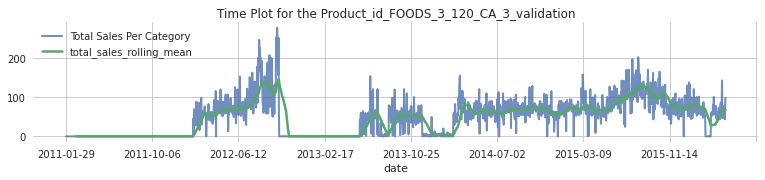

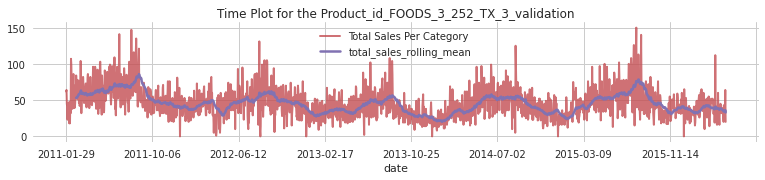

In [ ]:
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_WI_3_validation']], "Product_id_FOODS_3_586_WI_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_CA_1_validation']], "Product_id_FOODS_3_090_CA_1_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_CA_3_validation']], "Product_id_FOODS_3_586_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_TX_2_validation']], "Product_id_FOODS_3_090_TX_2_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_120_CA_3_validation']], "Product_id_FOODS_3_120_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_252_TX_3_validation']], "Product_id_FOODS_3_252_TX_3_validation")

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634


In [ ]:
def plotly_time_plot_markers(df, text, samples_onwards=1000):

    '''
    plots time_series plotly scatter plot of the format specified in df 
    
    inputs: df(dataframe), text(title text ), samples_onwards (time_series_sample and the end)
    returns : plotly time series scatter plot
    
    '''
    fig = go.Figure()
    for c in df.columns[:4]:
        fig.add_traces(go.Scatter(x=train_sales_cal_df[samples_onwards:].index, 
                              y=train_sales_cal_df[samples_onwards:][c],
                              mode='markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()    

plotly_time_plot_markers(train_sales_cal_df, 'Category')  

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['state_id'])[d_cols].sum().T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
#train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df

,CA,TX,WI
date,,,
2011-01-29,14195,9438,8998
2011-01-30,13805,9630,8314
2011-01-31,10108,6778,6897
2011-02-01,11047,7381,6984
2011-02-02,9925,5912,3309
...,...,...,...
2016-04-20,15148,9600,10595
2016-04-21,14488,9602,10943
2016-04-22,17095,10615,12807


In [ ]:
from plotly.subplots import make_subplots

def plotly_time_plot_rolling(df, text, start_col=0, end_col=3, rolling_days=30):

    '''
    time series rolling plots of the categories specified in df
    inputs: df (dataframe with ts as index, and columns as categories), text (title of the plot)
            rolling_days (number of rolling days)
    
    returns: plotly time series plot of sales along the categories specified as columns in df
    '''
    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   

plotly_time_plot_rolling(train_sales_cal_df, 'State')

In [ ]:
#referring to the solution provided at https://stackoverflow.com/questions/43223615/join-dataframes-one-with-multiindex-columns-and-the-other-without

train_sales_cal_df = train_sales_df.groupby(['state_id', 'cat_id'])[d_cols].sum().T\
              .join(pd.concat([calendar_df.set_index('d')['date']], axis=1, keys=['dates']))
train_sales_cal_df.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning:

merging between different levels can give an unintended result (2 levels on the left,1 on the right)



,"(CA, FOODS)","(CA, HOBBIES)","(CA, HOUSEHOLD)","(TX, FOODS)","(TX, HOBBIES)","(TX, HOUSEHOLD)","(WI, FOODS)","(WI, HOBBIES)","(WI, HOUSEHOLD)",dates
d_1,10101,1802,2292,6853,879,1706,6224,1083,1691,2011-01-29
d_2,9862,1561,2382,7030,870,1730,5866,926,1522,2011-01-30


In [ ]:
select_cols_ca = [c for c in train_sales_cal_df.columns if 'CA' in c]
select_cols_tx = [c for c in train_sales_cal_df.columns if 'TX' in c]
select_cols_wi = [c for c in train_sales_cal_df.columns if 'WI' in c]
#train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
#train_sales_cal_df = 
df_CA = train_sales_cal_df.set_index('dates')[select_cols_ca]
df_TX = train_sales_cal_df.set_index('dates')[select_cols_tx]
df_WI = train_sales_cal_df.set_index('dates')[select_cols_wi]

#df_CA.columns = [col[1] for col in df_CA.columns]
#df_TX.columns = [col[1] for col in df_TX.columns]
#df_WI.columns = [col[1] for col in df_WI.columns]

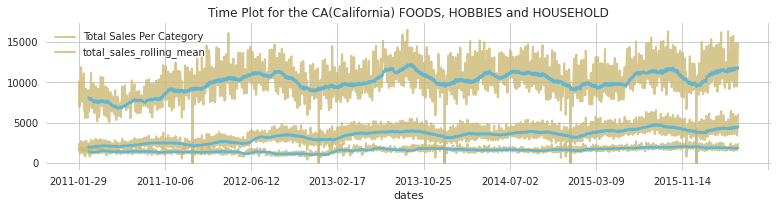

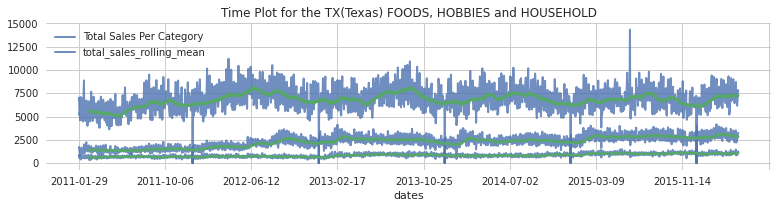

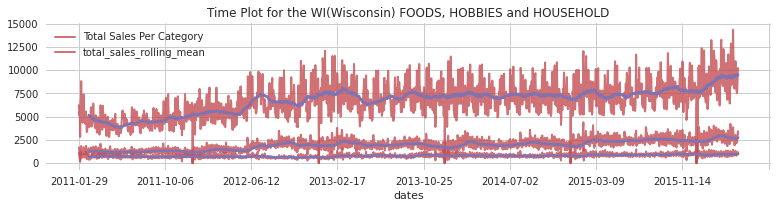

In [ ]:
time_and_rolling_plot(df_CA, 'CA(California) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_TX, 'TX(Texas) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_WI, 'WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
#time_and_rolling_plot(df_CA.iloc[:,1].reset_index(), "CA HOBBIES")
#time_and_rolling_plot(df_CA.iloc[:,2].reset_index(), "CA State")

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum()

In [ ]:
item_ids = [c for c in train_sales_cal_df.columns if 'validation' in c]

In [ ]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year

In [ ]:
df = train_sales_cal_df.groupby(['year', 'month'])[item_ids].sum()
df = df.reset_index()

In [ ]:
def find_items_per_specific_date(df, year, month, category, number):
    
    '''
    finds the five most sold product_ids in user specified category, year and month
    
    inputs: df(item_ids along with year and month), year, month, category (household, 
    foods or hobbies), number (how many results to be displayed)
    
    returns : table of product ids with specfied number and date and number of sales made
    '''
    
    df = df.loc[(df['year'] == year) & (df['month'] == month)][item_ids].T.reset_index()
    df.columns = ['item_id', 'sales_count']
    df = df.set_index('item_id')
    item_type = [c for c in df.index if category in c]
    df = df[df.index.isin(item_type)]
    df = df.sort_values(by = ['sales_count'], ascending=False)[:number]
    
    return df

print("Most sold Foods during requested date\n"
      ,find_items_per_specific_date(df, 2012, 7, 'FOODS', 5) )
print("Most sold Household items during requested date\n" 
      ,find_items_per_specific_date(df, 2013, 3, 'HOUSEHOLD', 5) )

Most sold Foods during requested date
                              sales_count
item_id                                 
FOODS_3_090_CA_3_validation         8054
FOODS_3_281_CA_3_validation         3851
FOODS_3_586_TX_2_validation         3458
FOODS_3_120_CA_3_validation         2940
FOODS_3_090_CA_1_validation         2780
Most sold Household items during requested date
                                  sales_count
item_id                                     
HOUSEHOLD_1_334_CA_3_validation         1346
HOUSEHOLD_1_118_CA_3_validation         1253
HOUSEHOLD_1_351_CA_3_validation         1043
HOUSEHOLD_1_277_CA_3_validation         1014
HOUSEHOLD_1_334_TX_1_validation          914


In [ ]:
train_sales_cal_df = train_sales_df.groupby(['store_id'])[d_cols].sum()\
                                                .T.merge(calendar_df.set_index('d')['date'], 
                                                        left_index=True, right_index=True,
                                                        validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198


In [ ]:
#PLOT one by one to avoid memory overload

#plotly_time_plot_rolling(train_sales_cal_df, 'Store')
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=4, end_col=7)
#plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=7, end_col=10)

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['day'] = train_sales_cal_df.date.dt.day
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.weekday
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.day_name()
train_sales_cal_df.head(2)

,date,FOODS,HOBBIES,HOUSEHOLD,month,day,year,weekday
0,2011-01-29,23178,3764,5689,1,29,2011,Saturday
1,2011-01-30,22758,3357,5634,1,30,2011,Sunday


In [ ]:
df_food = train_sales_cal_df.groupby(['weekday', 'day'])['FOODS'].sum().reset_index(name='sales')
df_house = train_sales_cal_df.groupby(['weekday', 'day'])['HOUSEHOLD'].sum().reset_index(name='sales')
df_hob = train_sales_cal_df.groupby(['weekday', 'day'])['HOBBIES'].sum().reset_index(name='sales')

In [ ]:
def heatmap_plot_dates(df, title_text):

    '''
    returns the heatmap based plot for the df with time_series data in it
    
    inputs : df (dataframe with time based elements, such as weekdays, months etc.)
             title_text (text of the plot to be shown)
    returns : Heatmaps of Weekdays along number of days of a months
    '''
    fig = make_subplots(rows=1, cols=1, vertical_spacing = 0.15, 
                    subplot_titles=title_text,
                    shared_yaxes = True
                   )
    fig.add_trace( go.Heatmap(
                   z=[[df.loc[(df['day'] == day) & (df['weekday'] == weekday)]['sales'].sum()
                     for day in range(1, 31+1)] for weekday in df.weekday.unique()],
                   x=list(df.day.unique()),
                   y=list(df.weekday.unique()),
                   hoverongaps = False, 
                   colorbar = dict(title= title_text + '_Sales', 
                                   thickness=15)), row=1, col=1)
    fig.update_layout(title = title_text + '_Sale Distribution', height=2 * 20 + 300, width=1 * 700, showlegend=False)
    fig.show()

In [ ]:
heatmap_plot_dates(df_food, 'FOODS')
heatmap_plot_dates(df_hob, 'HOBBIES')
heatmap_plot_dates(df_house, 'HOUSEHOLD')

# Time Series Forecasting

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1")
train_sales_cal_df['avg_sales'] = train_sales_cal_df.mean(axis=1)

In [ ]:
##train_sales_cal_df = train_sales_cal_df[['total_sales']]
##train_sales_cal_df = train_sales_cal_df.reset_index()
##train_sales_cal_df = train_sales_cal_df.set_index('date')

train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df.rename(columns={'index': 'daysnum'}, inplace=True)
train_sales_cal_df = train_sales_cal_df.set_index('date').asfreq('d')
train_sales_cal_df.head(2)

,daysnum,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,...,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation,avg_sales
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,d_1,0,0,0,0,0,0,0,12,2,...,14,1,0,4,0,0,0,0,0,1.070220
2011-01-30,d_2,0,0,0,0,0,0,0,15,0,...,11,1,0,4,0,0,6,0,0,1.041292


In [ ]:
train_sales_cal_df.index = pd.to_datetime(train_sales_cal_df.index)
type(train_sales_cal_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
def time_series_stationary_test(df):
    
    '''
    returns time_series plots along with rolling mean plot, standard_dev calculated plot
    and results of the Dickey_Fuller Test performed on time_series df
    
    inputs: df (time_series based df)
    
    returns : time_series plot, rolling_mean plot, std_plot and Dickey_Fuller Test Statistics
              performed on time_series
    '''
    #df_filter = df.loc[df['id'] == series_ids][d_cols]
    #df_filter = df.loc[df['id'] == series_ids]['sold']
    #df_filter = pd.Series(df_filter.values.flatten())
    
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    
    rolling_mean = df.rolling(window=7).mean()
    rolling_std =  df.rolling(window=7).std()
    
    #plotting the points
    original_series = df.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, color=next(color_cycle), label='original_series', ax=ax1)
    mean_series = rolling_mean.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = 'o', color=next(color_cycle), label='rolling_mean', ax=ax1)
    std_series = rolling_std.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = '*' , color=next(color_cycle), label='rolling_std', ax=ax1)
    
    ax1.legend(['Original_Series', 'Mean_Series', "Std_Series"])
    plt.show()
    
    #Performing a Dickey-Fuller Test
    print("\n============++++==========\n")
    print("Results of the Dickey_Fuller Test")
    result = adfuller(df, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('No of lags: %f' %result[2])
    print('No of Obs used for ADF Calculation & Critical Values: %f' %result[3])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    #output = pd.Series(result[0:4], index=['ADF Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for key,value in result[4].items():
    #    output['Critical Value (%s)'%key] = value
    #print (output)

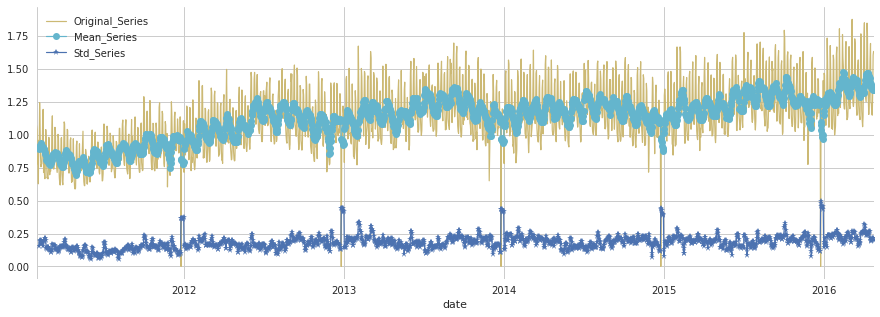


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -1.565373
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1886.000000
p-value: 0.500960
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
time_series_stationary_test(train_sales_cal_df[['avg_sales']])

In [ ]:
df_log_diff = np.log(train_sales_cal_df[['avg_sales']]) - np.log(train_sales_cal_df[['avg_sales']]).shift()
#df['sold'] = df_log_diff
#df['sold'] = df['sold'].dropna()
df_log_diff = df_log_diff.dropna()

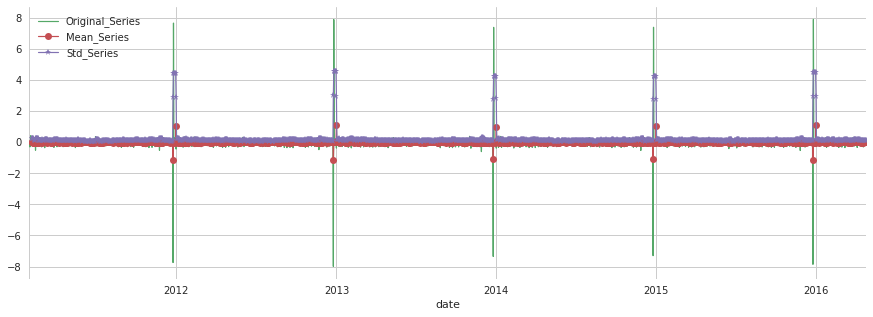


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -16.908187
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1885.000000
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
time_series_stationary_test(df_log_diff)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):
    
    '''
    returns the trend, seasonality, and residual components decomposition of time_Series and
    plots the results 
    
    inputs: df(time_series df along with sales specified), model_specified (whether to use
            additive or multiplicative), period (number of days where seasonality 
            is to be observed)
    returns: decomposition plots along with decomposition components, in trend, seasonality
    and residuals
    '''

    df_decomposition = seasonal_decompose(
                               x=df, 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 24))

    df.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax1)
    est_trend.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax2)
    est_seasonal.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax3)
    est_residual.plot(figsize=(14, 8) ,
                 alpha=0.6, 
                 lw=3, style = 'o', ax = ax4)

    fig.tight_layout()
    plt.show()
    
    return est_trend, est_seasonal, est_residual

#sample_time_s1 = train_sales_cal_df[400:700]
#est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 'multiplicative', 15)

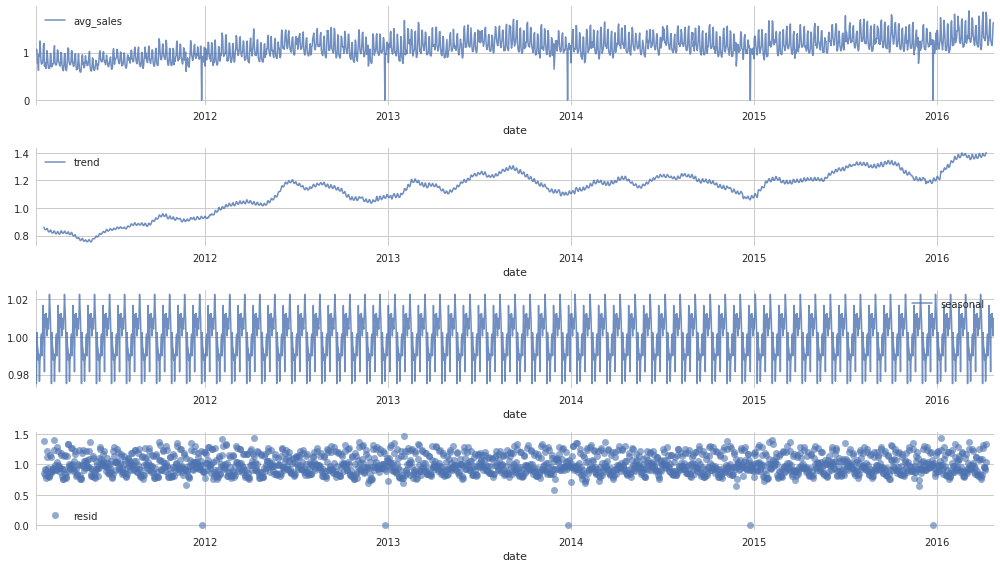

In [ ]:
trend_comp, seas_comp, residual_comp = time_series_decompose(train_sales_cal_df[['avg_sales']], 'multiplicative', 30)

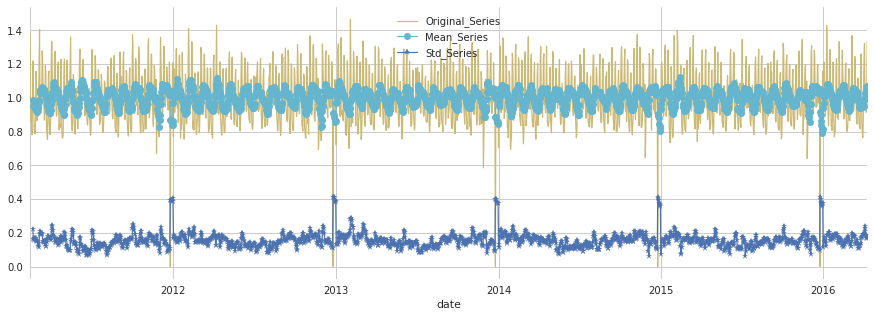


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -26.316735
No of lags: 25.000000
No of Obs used for ADF Calculation & Critical Values: 1857.000000
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
residual_comp = residual_comp.dropna()
time_series_stationary_test(residual_comp)

## ACF & PACF: Finding Pdq Visually?

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

def auto_par_corr(ts_stat, nlags=25): 

    '''
    returns the ACF and PACF plots of the time series
    
    inputs: ts_stat (time series along with data), nlags (optimal number of lags)
    
    returns: plot of ACF and PACF
    '''
    lag_acf = acf(ts_stat, nlags)
    lag_pacf = pacf(ts_stat, nlags, method='ols')
    
    sns.set_style("whitegrid")

    
    plt.figure(figsize=(15, 8))
    plt.subplot(121)
    #plt.plot(lag_acf)
    plt.stem(lag_acf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Auto-Correlation')
    
    #lag_pacf.plot(figsize=(15, 5), alpha=1, 
    #                    lw=3, color=next(color_cycle), label='par_corr', ax=ax2)
    plt.subplot(122)
    #plt.plot(lag_pacf)
    plt.stem(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Partial Auto-Correlation')
    
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be adde

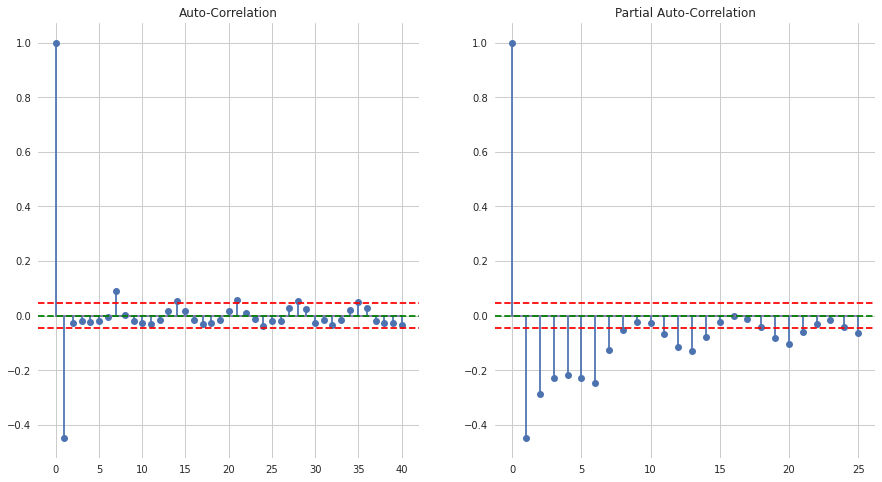

In [ ]:
auto_par_corr(df_log_diff, nlags=25)

In [ ]:
#Let us split the time series into training and testing sets
#perc_training = 0.7
#split_p = round(len(train_sales_cal_df['avg_sales']) * perc_training)
#training_p, testing_p = train_sales_cal_df['avg_sales'][0:split_p], train_sales_cal_df['avg_sales'][split_p:]

training_p = train_sales_cal_df.loc[:'2015-10-14', ['avg_sales']]
testing_p = train_sales_cal_df.loc['2015-10-15':, ['avg_sales']]
training_p.head(2)

,avg_sales
date,
2011-01-29,1.070220
2011-01-30,1.041292


## Making Exogeneous Factors

In [ ]:
#for prophet model:
df_event_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': calendar_df[~calendar_df['event_name_1'].isna()]['date']})
df_event_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': calendar_df[~calendar_df['event_name_2'].isna()]['date']})
df_snapca = pd.DataFrame({'holiday': 'snap_CA', 'ds': calendar_df[calendar_df['snap_CA'] == 1]['date']})
df_snaptx = pd.DataFrame({'holiday': 'snap_TX', 'ds': calendar_df[calendar_df['snap_TX'] == 1]['date']})
df_snapwi = pd.DataFrame({'holiday': 'snap_WI', 'ds': calendar_df[calendar_df['snap_WI'] == 1]['date']})
holidays = pd.concat((df_event_1, df_event_2, df_snapca, df_snaptx, df_snapwi))
holidays.head(3)

,holiday,ds
8,Event 1,2011-02-06
16,Event 1,2011-02-14
23,Event 1,2011-02-21


In [ ]:
#ever since spliting exo, it is to be added additionally
holidays['ds'] = pd.to_datetime(holidays['ds'])

In [ ]:
# for SARIMAX Model:

data = {'date':train_sales_cal_df.index,
        'holidays': 0 }

exo = pd.DataFrame(data)

for idx, date1 in enumerate(exo['date']):
    for date2 in holidays['ds']:
        if date2 == date1:
            exo['holidays'].iloc[idx] = 1
        else:
            continue

In [ ]:
exo = exo.set_index(['date']).asfreq('D')
exo.head(4)

,holidays
date,
2011-01-29,0
2011-01-30,0
2011-01-31,0
2011-02-01,1


## Validation SARIMAX

                                     SARIMAX Results                                     
Dep. Variable:                         avg_sales   No. Observations:                 1720
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood                1485.773
Date:                           Sun, 23 Oct 2022   AIC                          -2957.546
Time:                                   14:12:51   BIC                          -2919.494
Sample:                               01-29-2011   HQIC                         -2943.457
                                    - 10-14-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3601      0.013     26.946      0.000       0.334       0.386
ar.L2          0.1133      0.022      5.088

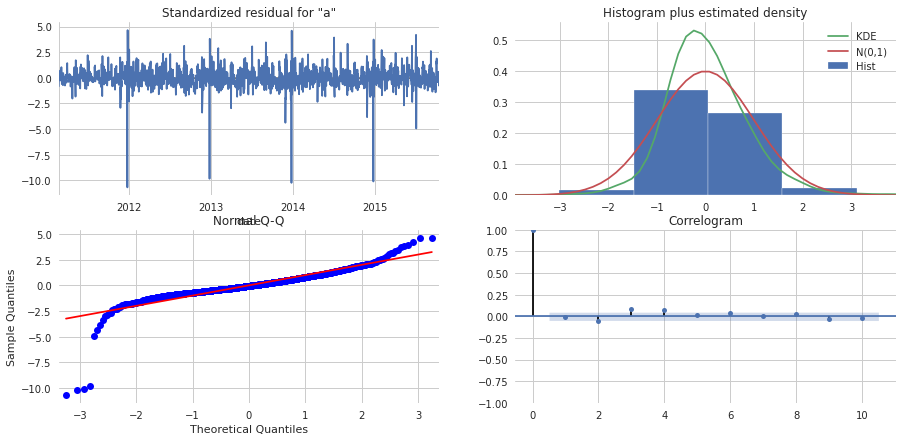

In [ ]:
#Fitting in the SARIMAX Model
#include the exo_train in here , exo_test in prediction (model_fit_SARIMAX) to check results: for now, abandoning their use because
# of the error in package, since even converting exo_train, exo_test into time series/using df results
# in errors. 
#model values earlier 1,1,1, 0,1,1,7 
#values with RMSE - order=(2,1,1), seasonal_order=(2,1,1,7), 
model = SARIMAX(training_p,
                order=(2,1,1), seasonal_order=(2,1,1,7), 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(15,7))
plt.show()
#information on whether particular model is a goodfit
#https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

## SARIMAX Graphical Validation & Forecasting

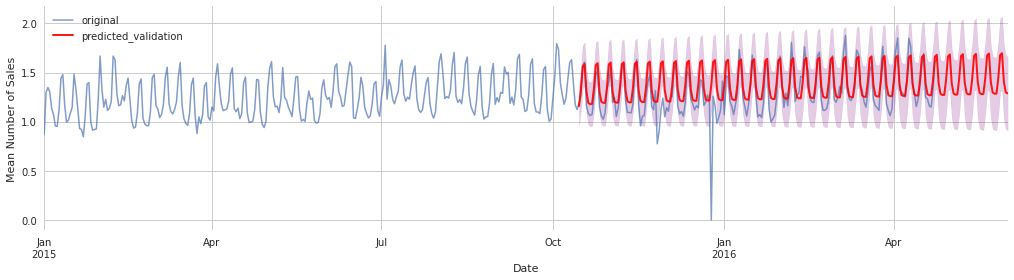

In [ ]:
def model_fit_SARIMAX(model_set, model_fit_srt_tm='2015-10-15', ts_st_tm='2013'):
    
    '''
    makes predictions using SARIMAX model tuned earlier and returns plots along with 
    predictions made
    
    inputs: model_set (model tuned), model_fit_srt_tm (model prediction starting time), 
            ts_st_tm (time series plot to be plotted beginning point)
    returns: forecast plot along with time_series, and pred (predictions made series)
    
    '''
    
    #1.# pred = model_fit.forecast(len(testing_p), alpha=0.05, dynamic=False)  # 95% conf
    pred = model_set.get_prediction(start=pd.to_datetime(model_fit_srt_tm), end='2016-06-01', dynamic=False)
    pred_conf = pred.conf_int()
    #for dynamic prediction of time_series:
    #pred_dy = model_set.get_prediction(dynamic=pred_srt_tm)
    #pred_dy_conf = pred_dy.conf_int()

    # Make as pandas series
    #pred_series = pd.Series(pred, index=testing_p.index)

    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 4))

    train_sales_cal_df['avg_sales'][ts_st_tm:].plot(label='original',
                                                  alpha=0.7, 
                                                  lw=1.5 , ax=ax1)
    pred.predicted_mean.plot(label='predicted_validation',
                             alpha=0.9, color='red',
                             lw=2, ax=ax1)
    ax1.fill_between(pred_conf.index, 
                     pred_conf.iloc[:,0], 
                     pred_conf.iloc[:, 1], color='purple', alpha=0.2)
    fig.tight_layout()
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Number of Sales')
    plt.legend(loc='upper left')
    plt.show()
    
    return pred

pred_made = model_fit_SARIMAX(model_fit, ts_st_tm='2015') 

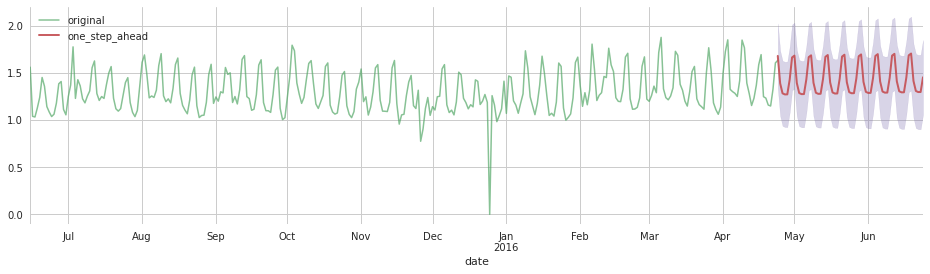

In [ ]:
#Making Future Prediction:
#note: exo_sub = exo.loc['2016-01-25':], if it is needed to provide the holidays , equate exo_sub to exog in get forecast

#pred_future = model_fit.get_forecast(steps=90) #Making Prediction for next 3 months

pred_future = model_fit.get_prediction(start='2016-04-24', end='2016-06-24', dynamic=False)
pred_f_conf = pred_future.conf_int()

fig, ax2 = plt.subplots(figsize=(16, 4))


#now using the entire original series, instead of training or testing:

train_sales_cal_df['avg_sales']['2015-06-15':].plot(label='original',
                 alpha=0.7, 
                 lw=1.5 , color=next(color_cycle), ax=ax2)

pred_future.predicted_mean.plot(label='one_step_ahead',
                 alpha=0.9, 
                 lw=2, color=next(color_cycle), ax=ax2)

ci = pred_f_conf.loc['2016-04-24':]

ax2.fill_between(ci.index, 
                ci.iloc[:,0], 
                ci.iloc[:, 1], color=next(color_cycle), alpha=0.3)

plt.legend(loc='upper left')
plt.show()

## Fb Prophet: Training and Validation Data Split

In [ ]:
#prophet forecast from here
from fbprophet import Prophet
from tqdm.notebook import tqdm as tqdm

####Observing behavior of Avg Number of Sales using Prophet#######
####Converting the data into required ds and y format for Prophet Model#####

ts = train_sales_cal_df[['avg_sales']].reset_index()
ts = ts.set_axis(['ds', 'y'], axis=1, inplace=False)

#####Specifying data for only one year to better visulize future predictions#######
threshold_date = pd.to_datetime('2015-04-22') 
select_d = ts ['ds'] > threshold_date

ts = ts[select_d][['ds', 'y']]

#####prophet_plot(ts)######

mod_params = { 'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 
sales_model = Prophet(**mod_params, interval_width=0.95)
#data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used

######fitting the prophet model########

sales_model.fit(ts)
future = sales_model.make_future_dataframe(28, 'D')
#future['cap'] = data['cap'].max() #incase logistic model growth used in params
sales_forecast = sales_model.predict(future)

########Train/Test split of Data#######################

threshold_date = pd.to_datetime('2016-03-01') #for the test/validation split
forecast_date = pd.to_datetime('2016-04-24') #for the actual forecast date to begin
select_d = ts ['ds'] < threshold_date

ts_train = ts[select_d][['ds', 'y']]
ts_test = ts[~ select_d][['ds', 'y']]

select_d2 = sales_forecast['ds'] < forecast_date


forecast_train = sales_forecast[select_d2]
forecast_test = sales_forecast[~ select_d2]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Prophet Forecasting On Average Sales Using Seaborn

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Avg Sales of Units')]

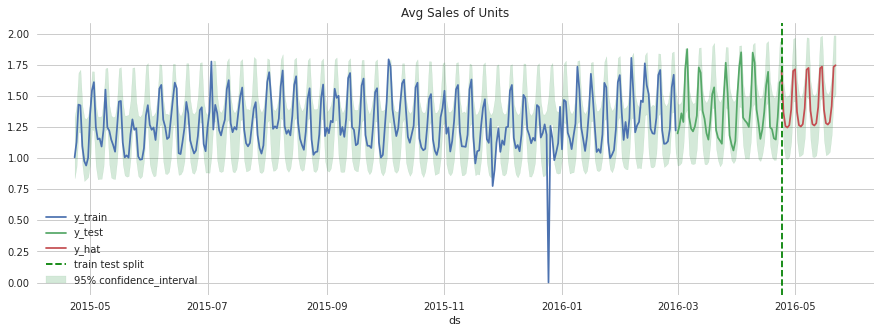

In [ ]:
#Seaborn based plot for the fb_Prophet Model
sns.set_style('whitegrid')
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(15,5))

ax.fill_between(
    x=sales_forecast['ds'], y1=sales_forecast['yhat_lower'], y2=sales_forecast['yhat_upper'],
    color=sns_c[2],  alpha=0.25, label=r'95% confidence_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=ts_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=ts_test, ax=ax)
#sns.lineplot(x='ds', y='yhat', label='y_hat', data=sales_forecast, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.axvline(forecast_date, color='g', linestyle='--', label='train test split')

ax.legend(loc='lower left')
ax.set(title='Avg Sales of Units', ylabel='')

## Custom Loss Function For Fb Prophet Tuning

In [ ]:
#selecting the product ids for which we require prophet prediction

id1 = 'FOODS_3_443_CA_1_validation'
id2 =  'HOUSEHOLD_1_005_CA_3_validation'
id3 =  'FOODS_3_823_WI_3_validation'
id4 = 'FOODS_3_090_CA_3_validation'
id5 = 'FOODS_3_586_TX_2_validation'
id6 = 'FOODS_3_586_TX_3_validation'

#train_sales_cal_df[id2]

In [ ]:
def make_id_timeseries(idx, date='2016-02-22'):
    
    '''
    selects and makes the timeseries adjusted for fb prophet model by adjusting names
    of columns
    
    inputs: product_id
    
    returns: time series with data specified in format for prophet
    
    '''
    
    dates_series = [date for date in train_sales_cal_df.index]
    id_series =  train_sales_df[(train_sales_df.id == idx )]
    item_ts = pd.DataFrame({'ds': dates_series}, index=range(len(dates_series)))
    item_ts['y'] = id_series[d_cols].values[0].transpose()
    
    ######Following steps would shorten the behavior of historic timeline data########
    ######Choosing the threshold date near to the date where prediction needs to be made 
    ######because of close correlation in time series
    
    threshold_date = pd.to_datetime(date) 
    mask = item_ts['ds'] > threshold_date

    item_ts = item_ts[mask][['ds', 'y']]
    
    return item_ts

data1 = make_id_timeseries(id6)
data4 = make_id_timeseries(id4)

In [ ]:
##########New Code Working For Custom Error###########
import itertools
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Note : the code was generated using the explanation at the following link
#https://www.baeldung.com/cs/mape-vs-wape-vs-wmape

def fbprophet_tuning_per_single_id(id_data, changepoint_prior_list=[0.5, 0.6, 0.7], 
                                   changepoint_range_list=[0.6, 0.7, 0.8], 
                                   n_changepoints_list=[50, 60]):
    param_grid = {  
        'changepoint_prior_scale': changepoint_prior_list,
        'changepoint_range': changepoint_range_list,
        'n_changepoints' : n_changepoints_list
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    #wapes = []  # Store the RMSEs for each params here
    wmapes = []

    # Use cross validation to evaluate all parameters
    for params in all_params:
        mod = Prophet(**params).fit(id_data)  # Fit model with given params
        df_cv = cross_validation(mod, initial = '32 days', period = '3 days', horizon='28 days')
        #df_p = performance_metrics(df_cv, rolling_window=1)
        #rmses.append(df_p['rmse'].values[0])
        #wapes.append(np.sum(df_cv['yhat'] - df_cv['y']) / (np.sum(df_cv['y'])))
        weighted_coeff = (df_cv['yhat'] - df_cv['y'])/(df_cv['yhat'] - df_cv['y']).mean()
        wmapes.append(np.sum((df_cv['yhat'] - df_cv['y']) * weighted_coeff )/ np.sum(weighted_coeff*df_cv['y']) )

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['wmape'] = wmapes
    print(tuning_results)
    
fbprophet_tuning_per_single_id(data1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 36.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 36.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 42.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 42.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 48.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 26.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 48.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 26.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 36.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 36.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 42.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 42.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 48.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 26.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 48.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 26.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 36.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 36.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 42.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 42.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 48.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 26.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 48.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-03-27 00:00:00 and 2016-03-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 26.


    changepoint_prior_scale  changepoint_range  n_changepoints     wmape
0                       0.5                0.6              50  0.503055
1                       0.5                0.6              60  0.503055
2                       0.5                0.7              50  0.700986
3                       0.5                0.7              60  0.700986
4                       0.5                0.8              50  1.505614
5                       0.5                0.8              60  1.505614
6                       0.6                0.6              50  0.535218
7                       0.6                0.6              60  0.535218
8                       0.6                0.7              50  0.716194
9                       0.6                0.7              60  0.716194
10                      0.6                0.8              50  1.664200
11                      0.6                0.8              60  1.664200
12                      0.7                0.6     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1080x216 with 0 Axes>

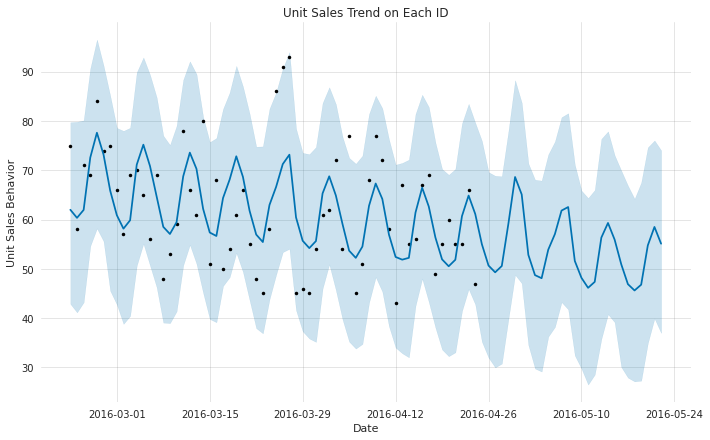

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1080x216 with 0 Axes>

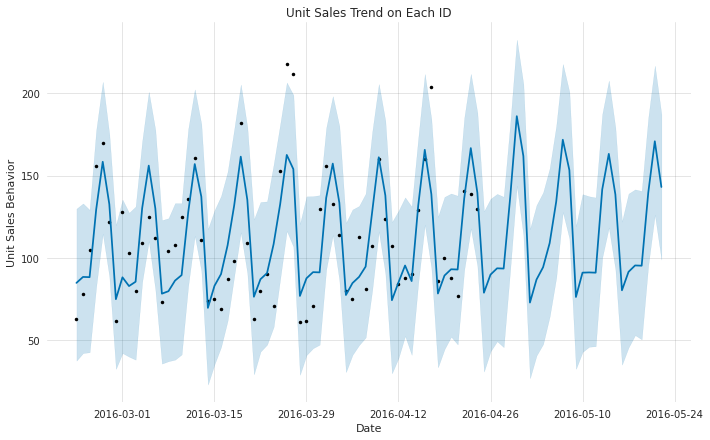

In [ ]:
def prophet_plot(data, periods=28, freq='D'):
    
    '''
    plots the fb prophet model for the data of id specified
    
    inputs: data (product id along with data for previous days), periods(predictions for 
    the next days to be made)
    
    returns: plots the immediate historic data along with forecast for the future made
    '''
    
    mod_params = { 'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 

    sales_model = Prophet(**mod_params, holidays=holidays, interval_width=0.95)
    #data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used
    #fitting the model
    sales_model.fit(data)
    future = sales_model.make_future_dataframe(periods, freq)
    #future['cap'] = data['cap'].max() #incase logistic model growth used in params

    sales_forecast = sales_model.predict(future)
    
    plt.figure(figsize=(15,3))
    #fig, ax = plt.subplots(figsize=(14,5))
    sales_model.plot(sales_forecast, xlabel='Date', ylabel='Unit Sales Behavior')
    #plt.axvline(x=sales_forecast[sales_forecast.ds == '2016-04-22']['ds'], color='r')
    #ax.axvline(threshold_date, color='g', linestyle='--', label='Prediction Onwards')
    #ax.legend(loc='upper left')
    #ax.set(title='Avg Sales of Units', ylabel='');
    plt.title("Unit Sales Trend on Each ID")
    plt.show()


prophet_plot(data1)
prophet_plot(data4)

In [ ]:
all_ids = train_sales_cal_df.columns.drop(['daysnum', 'avg_sales'])
sales_forecast_list = []

def prophet_pred_df(start=15500, end=15650):
    '''
    makes a dataframe with prophet predictions made for each product_id 
    
    input: start = product_id start, end = product_id to be the last one for prediction
    
    returns: dataframe with predictions made for the next 28 days using prophet of the product
             ids specified in input
    '''

    for idc in tqdm(range(start, end)):
        train_sub = train_sales_cal_df.iloc[-28:, idc].reset_index()
        idx = train_sub.columns[1]
        train_sub.set_axis(['ds', 'y'], axis=1, inplace=True)
        mod_params = { 'changepoint_prior_scale': 0.5 , 'changepoint_range': 0.6,
                      'n_changepoints': 50, 
                      'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 
        sales_model = Prophet(**mod_params, interval_width=0.95)
        #data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used

        ######fitting the prophet model########
        
        sales_model.fit(train_sub)
        future = sales_model.make_future_dataframe(28, 'D')
        #future['cap'] = data['cap'].max() #incase logistic model growth used in params
        sales_forecast = sales_model.predict(future)[-28:]
        sales_forecast_list.append( (np.append(np.array([idx]), sales_forecast['yhat'].values.transpose())) )
    
    return sales_forecast_list

#list_table would collect all entries

list_table = prophet_pred_df()

  0%|          | 0/150 [00:00<?, ?it/s]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

In [ ]:
#changing column names to those as specified in submission file
df_prophet_forecast = pd.DataFrame(list_table)
df_prophet_forecast.columns = submission_file.columns
#df_prophet_forecast = df_prophet_forecast.round(decimals = 2)
df_prophet_forecast.head(6)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_262_TX_2_validation,-0.09097927031668591,-0.3210630485311665,-0.09609752107812408,0.5406369146215464,-0.11499830579444224,2.0648550607906992,-0.13126255012832275,-0.1686757308034125,-0.5654376992707334,...,-0.24699923611071614,4.255399816983883,-0.2607063770695052,-0.3240686517888161,-1.0541870007662255,-0.2940093103443121,1.5546295287420466,-0.31299970127798676,5.3506721950819705,-0.3254282905389703
1,HOBBIES_1_263_TX_2_validation,-0.0031262053896119637,-0.0016539338880396368,0.005335209681017311,-0.01896995249757156,0.003203991848043139,-0.0751939297764165,-0.07103649870574644,0.007176259081157083,0.008645473872633216,...,0.02711561990788609,-0.44124075184677286,-0.3276247254532499,0.02778118802315633,0.029244289394701892,-0.8974993933862508,-0.47377964318162125,0.03907143393914124,-0.624264162881776,-0.45591883882648676
2,HOBBIES_1_264_TX_2_validation,0.5687605369909011,0.25940467440127957,0.2597781504928447,0.40264565281735576,1.0584044472290868,0.6566933342343972,0.7423922227742692,0.6316917919871002,0.2876602200055552,...,1.27869344717189,0.7913707523868105,0.8924469948393614,0.7575543019811497,0.3441713112166144,0.34336614557771017,0.5302485125007301,1.3888379471428849,0.8587094614619525,0.9674743808713457
3,HOBBIES_1_265_TX_2_validation,0.2728192806375166,0.19388097774926089,0.00028439183084530363,0.15098289941684492,0.14003613544211824,0.21264618374449476,0.2502917249484612,0.13024561866346132,0.08438545709624161,...,-0.06864543213866814,-0.1419868324482301,-0.22357096078227456,-0.1549017052853734,-0.13460558421043747,-0.00023973038873401916,-0.15404113457910626,-0.17298621592935262,-0.31930334054496157,-0.4605023036476925
4,HOBBIES_1_266_TX_2_validation,1.1223410661096345,0.4275448233479791,2.7022023589670403,1.8426742496942343,2.703300917550353,5.1930955805318675,5.553925162314996,1.3325855593785252,0.5055479622689784,...,3.618170817003495,6.9090975838794115,7.34684154177875,1.7530745459070065,0.6615542401203938,4.143638213669836,2.8012624972964146,4.075605766725637,7.7670985855546695,8.243299731508143
5,HOBBIES_1_267_TX_2_validation,-0.04549276589247395,-0.04298176581097742,1.2565671435837813,0.4691591897352781,-0.03323396784535504,0.8212822537874648,1.069345163633953,-0.06125714554822924,-0.05717348069915182,...,-0.052459782107522154,1.2775399598356116,1.6407386745407393,-0.09278590486206217,-0.08555691047258952,2.4451815379669757,0.8938188210843006,-0.062072689241291286,1.505668812859735,1.926435429992817


In [ ]:
########Remove Unwanted Columns###################
train_sales_df = train_sales_df.drop(['total_sales_all_days', 'avg_sales_all_days', 'median_sales_all_days'], axis=1)

###########Making the dataframe of predictions for all ids############
req_sales_df = train_sales_df.iloc[:, np.r_[0,-28:0]].melt('id', var_name='d', value_name='sale')
req_sales_df = req_sales_df.merge(calendar_df.loc[:,['d','date','wday']])
#req_sales_df
lastest_date = int(req_sales_df.d.max()[2:])
req_sales_df = req_sales_df.groupby(['id','wday'])['sale'].mean()
req_sales_df.head(7)

id                           wday
FOODS_1_001_CA_1_validation  1       0.75
                             2       0.50
                             3       3.00
                             4       0.75
                             5       1.50
                             6       0.25
                             7       1.50
Name: sale, dtype: float64

In [ ]:
###########Generating Submission Dataframe of ids for 28 next days with 0 values############

mv_avg_forecast = submission_file.copy()
mv_avg_forecast.columns = ['id'] + ['d_' + str(lastest_date + x) for x in range(1, 29)]
mv_avg_forecast = mv_avg_forecast.loc[mv_avg_forecast.id.str.contains('validation')]
#mv_avg_forecast

In [ ]:
###########Generating Dataframe for Moving Average Values###############

mv_avg_forecast = mv_avg_forecast.melt('id', var_name='d', value_name='sale')
mv_avg_forecast = mv_avg_forecast.drop('sale',axis = 1)
#mv_avg_forecast

mv_avg_forecast = mv_avg_forecast.merge(calendar_df.loc[:,['d','date','wday']])
mv_avg_forecast = mv_avg_forecast.join(req_sales_df, on=['id', 'wday'])
#mv_avg_forecast

mv_avg_forecast = mv_avg_forecast.pivot(index='id', columns='d', values='sale')
mv_avg_forecast = mv_avg_forecast.reset_index()
mv_avg_forecast

d,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS_1_001_CA_1_validation,3.00,0.75,1.50,0.25,1.50,0.75,0.50,3.00,0.75,...,1.50,0.75,0.50,3.00,0.75,1.50,0.25,1.50,0.75,0.50
1,FOODS_1_001_CA_2_validation,0.25,0.50,1.25,1.00,0.25,0.00,4.50,0.25,0.50,...,0.25,0.00,4.50,0.25,0.50,1.25,1.00,0.25,0.00,4.50
2,FOODS_1_001_CA_3_validation,0.25,0.00,0.50,0.00,0.00,1.50,3.75,0.25,0.00,...,0.00,1.50,3.75,0.25,0.00,0.50,0.00,0.00,1.50,3.75
3,FOODS_1_001_CA_4_validation,1.25,0.00,0.25,0.00,0.25,0.25,0.25,1.25,0.00,...,0.25,0.25,0.25,1.25,0.00,0.25,0.00,0.25,0.25,0.25
4,FOODS_1_001_TX_1_validation,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.25,...,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.25,...,0.00,0.25,0.50,0.25,0.25,0.50,0.25,0.00,0.25,0.50
30486,HOUSEHOLD_2_516_TX_3_validation,0.00,0.50,0.50,0.00,0.00,0.25,0.00,0.00,0.50,...,0.00,0.25,0.00,0.00,0.50,0.50,0.00,0.00,0.25,0.00
30487,HOUSEHOLD_2_516_WI_1_validation,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,...,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00
30488,HOUSEHOLD_2_516_WI_2_validation,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00


In [ ]:
#del mv_avg_forecast.index.name
mv_avg_forecast.rename_axis(None).index.name
mv_avg_forecast.head(4)

d,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS_1_001_CA_1_validation,3.00,0.75,1.50,0.25,1.50,0.75,0.50,3.00,0.75,...,1.50,0.75,0.50,3.00,0.75,1.50,0.25,1.50,0.75,0.50
1,FOODS_1_001_CA_2_validation,0.25,0.50,1.25,1.00,0.25,0.00,4.50,0.25,0.50,...,0.25,0.00,4.50,0.25,0.50,1.25,1.00,0.25,0.00,4.50
2,FOODS_1_001_CA_3_validation,0.25,0.00,0.50,0.00,0.00,1.50,3.75,0.25,0.00,...,0.00,1.50,3.75,0.25,0.00,0.50,0.00,0.00,1.50,3.75
3,FOODS_1_001_CA_4_validation,1.25,0.00,0.25,0.00,0.25,0.25,0.25,1.25,0.00,...,0.25,0.25,0.25,1.25,0.00,0.25,0.00,0.25,0.25,0.25


In [ ]:
#df_sub_valid = pd.concat([mv_avg_forecast, df_prophet_forecast_1, 
#                        df_prophet_forecast_2,df_prophet_forecast_3, 
#                        df_prophet_forecast_4, df_prophet_forecast_5, 
#                        df_prophet_forecast_6], sort=False)

#re-adjusting the old columns against new-ones

mv_avg_forecast.columns = submission_file.columns

df_valid = pd.concat([mv_avg_forecast[~mv_avg_forecast.id.isin(df_prophet_forecast.id)], df_prophet_forecast], sort=False)

df_eval = df_valid.copy()
df_eval['id'] = df_eval['id'].str.replace("validation", "evaluation")

submission_df = pd.concat([df_valid, df_eval], sort=False)
submission_df = submission_df.sort_values('id')

In [ ]:
submission_df.columns

Index(['id', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28'],
      dtype='object')